No
No
No
No
No
No


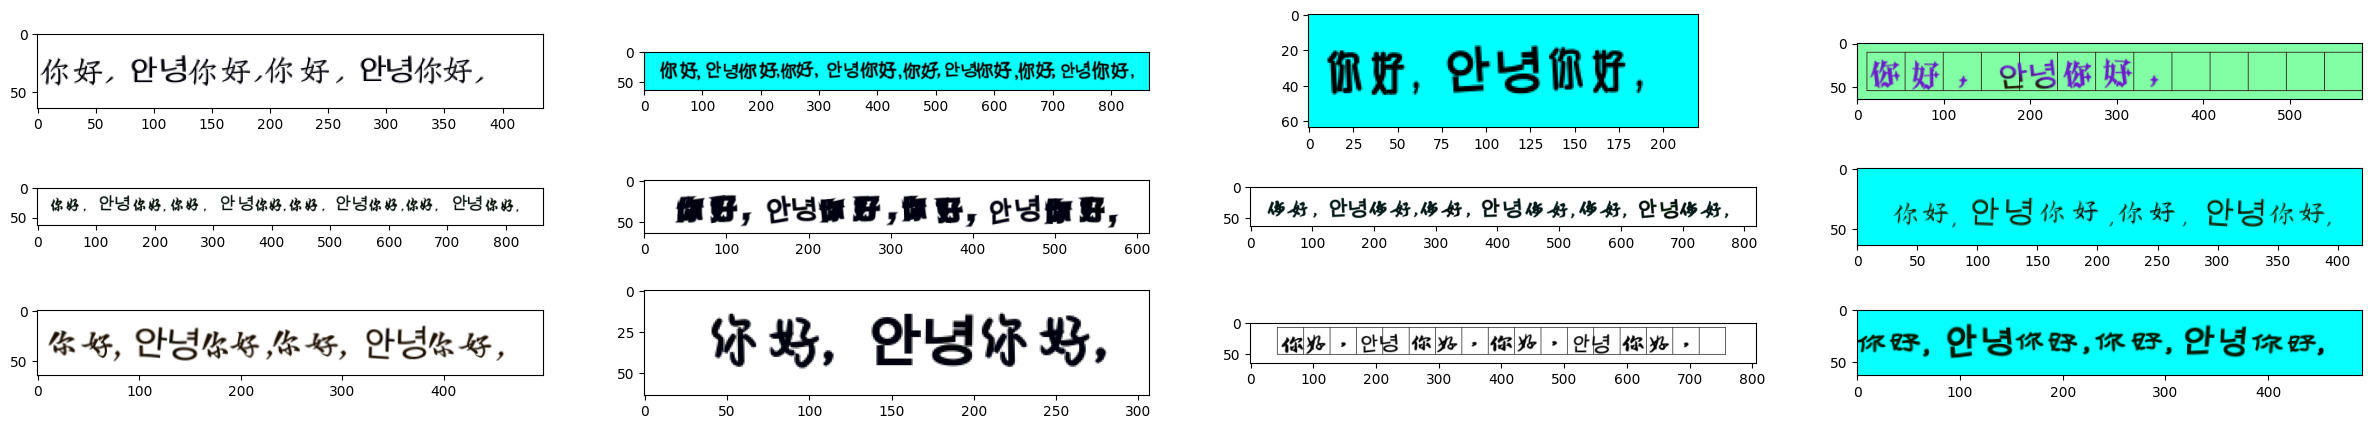

In [13]:
from data_aug_v2 import build_data_aug
from PIL import Image
from tqdm import tqdm
import random
import re

import cv2
import numpy as np
import pygame
import pygame.surfarray as surfarray
import pygame.freetype
from scipy.ndimage import gaussian_filter, map_coordinates
import matplotlib.pyplot as plt

from tang_syn_config import TextlineSynthesisConfig, can_render

# TODO: Punctuations at the end of the chinese grid line should not take one full space


def is_chinese(text):
    return re.search(r"[\u3000-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\uff01-\uff9f]", text)


def is_chinese_punct(text):
    return text in "，。！？"


def alpha_blend_with_mask(foreground, background, mask):  # modified func from link
    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Normalize the mask mask to keep intensity between 0 and 1
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask = mask.astype(float) / 255

    # Multiply the foreground with the mask matte
    foreground = cv2.multiply(mask, foreground)

    # Multiply the background with ( 1 - mask )
    background = cv2.multiply(1.0 - mask, background)

    # Add the masked foreground and background.
    return cv2.add(foreground, background).astype(np.uint8)


def elastic_transform(image, alpha, sigma):
    """Perform the elastic deformation"""
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(
        shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx,
                                                    (-1, 1)), np.reshape(z+dz, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode="reflect")
    return distored_image.reshape(image.shape)


def apply_mask_with_ellipses(image, num_ellipses=5):
    # Assumes image is in BGR format and the last channel is Alpha (transparency)
    bgr = image[:, :, :3]
    alpha = image[:, :, 3]

    # creates a white mask of the same size as the bgr
    mask = np.ones(bgr.shape, dtype=bgr.dtype) * 255

    h, w = bgr.shape[:2]

    for _ in range(num_ellipses):
        # Generate random parameters for the ellipse
        center = (random.randint(0, w), random.randint(0, h))
        # limiting the size of the ellipse to 1/4th of the image dimensions
        axes = (random.randint(0, w // 4), random.randint(0, h))
        angle = random.randint(0, 360)
        startAngle = random.randint(0, 360)
        # making sure the endAngle is greater than the startAngle
        endAngle = random.randint(startAngle, startAngle + 180)
        color = (random.randint(0, 255), random.randint(0, 255),
                 random.randint(0, 255))  # generates a random BGR color
        thickness = -1

        # Draw the ellipse on the mask
        cv2.ellipse(mask, center, axes, angle, startAngle,
                    endAngle, color, thickness)

    # apply Gaussian blur to the mask to make the ellipses blend smoothly
    mask = cv2.GaussianBlur(mask, (15, 15), 10)

    # Only apply the mask to non-transparent (opaque) parts of the image
    for i in range(3):  # For each BGR channel
        bgr[:, :, i] = cv2.bitwise_and(bgr[:, :, i], mask[:, :, i], mask=alpha)

    # Combine the BGR and alpha channel back together
    image = cv2.merge([bgr, alpha])

    return image


def generate_smooth_sequence(n, min_val=0.0, max_val=1.0, sigma=0.5):
    max_diff = (max_val - min_val) * sigma / n
    # Generate an array of differences between consecutive numbers
    diffs = np.random.uniform(-max_diff, max_diff, size=n-1)

    # Initialize the array of numbers
    numbers = np.zeros(n)
    numbers[0] = np.random.uniform(min_val, max_val)

    # Fill in the array
    for i in range(1, n):
        numbers[i] = numbers[i-1] + diffs[i-1]

    # Clip the numbers above max_val or below min_val
    numbers = np.clip(numbers, min_val, max_val)

    return numbers


class TextlineSynthesis:
    def __init__(self, config):
        self.config = config

    def get_grid_size(self):
        if self.config.chinese_grid:
            return self.config.font_size + self.config.chinese_grid_padding
        return self.config.graph_grid_size

    def draw_text(self, message):
        """Draw text on a surface with transparent background"""

        # Calculate maximum ascent and descent for baseline alignment
        fonts, font_metrics = self.generate_fonts_and_metrics(message)

        # Run is_chinese on all of the characters
        is_chinese_char = [is_chinese(char) for char in message]

        text_height = max_descent = max(
            font_metric[3] for font_metric in font_metrics)

        # Set grid size
        grid_size = self.get_grid_size()

        ####### Define starting positions #######
        start_pos_x = self.config.margin_left

        extra_left = None
        extra_right = None

        # Add extra Chinese char grids to the left side
        if self.config.chinese_grid:
            extra_left = int(np.random.normal(
                self.config.chinese_grid_extra_left, 2))
            extra_left = max(0, extra_left)

            # Approximate to 20 grids
            if self.config.chinese_grid_fill:
                extra_right = random.randint(
                    0, max(2, self.config.chinese_grid_fill_to - len(message)))
            else:
                extra_right = int(np.random.normal(
                    self.config.chinese_grid_extra_right, 2))

            start_pos_x += extra_left * grid_size

        pos_x = start_pos_x

        # Calculate starting y-position to center the text vertically
        start_pos_y = self.config.margin_top + \
            (self.config.canvas_height - text_height) / 2

        chinese_punct_lift = None

        if self.config.chinese_grid:
            chinese_punct_lift = random.uniform(0.0, self.config.font_size / 3)

        pos_y = start_pos_y

        ###### Calculate gaps and skews ######

        base_gap = random.uniform(
            self.config.base_gap_min, self.config.base_gap_max)

        # Render each character separately with random gap
        base_skew = random.uniform(
            self.config.base_skew_min, self.config.base_skew_max)

        # Generate a smoothly varying font weights
        font_weights = generate_smooth_sequence(
            len(message), min_val=-1 / 128, max_val=1 / 16)

        if self.config.char_y_offset:
            y_offset_limit = self.config.char_y_offset
            y_jittors = generate_smooth_sequence(
                len(message), min_val=-y_offset_limit, max_val=y_offset_limit, sigma=0.8)

        # Create an empty list to hold the text surfaces and their positions
        text_surfaces_and_positions = []

        # Main render loop
        for i, char in enumerate(message):

            # Add random skew
            skew = np.random.normal(
                self.config.skew_mean, self.config.skew_std_dev)
            skew = int(base_skew + skew)

            font = fonts[i]
            style = pygame.freetype.STYLE_NORMAL if font_weights[
                i] < 0.0 else pygame.freetype.STYLE_STRONG
            font.strength = max(0.0, font_weights[i])

            # Render the character to temporary surface
            text_surface, _ = font.render(
                char, self.config.text_color, (255, 255, 255, 0), size=self.config.font_size,
                style=style, rotation=skew)

            # Correct the x-coordinate for Chinese grid characters
            char_pos_x = pos_x

            if self.config.chinese_grid:

                if i > 0 and not is_chinese_char[i] and is_chinese_char[i - 1]:
                    pos_x += np.random.normal(self.config.font_size, 2.0)
                    char_pos_x = pos_x

                if is_chinese_char[i]:
                    # Place the chinese character in the center of the grid
                    char_padding_left = np.random.normal(
                        (grid_size - text_surface.get_width()) / 2.0, 2.0)
                    char_pos_x += char_padding_left

            # Correct the y-coordinate for baseline alignment
            char_pos_y = pos_y + max_descent - font_metrics[i][3]

            if self.config.char_y_offset:
                char_pos_y += y_jittors[i]

            if self.config.chinese_grid and char in "，。":
                char_pos_y -= chinese_punct_lift

            # Store the text surface and its position
            text_surfaces_and_positions.append(
                (text_surface, (char_pos_x, char_pos_y)))

            if self.config.chinese_grid and i == len(message) - 1:
                # If chinese grid is enabled, and this is the last char
                used_grid = (pos_x - self.config.margin_left +
                             text_surface.get_width()) // grid_size + 1
                pos_x = self.config.margin_left + \
                    (used_grid + extra_right) * grid_size

            elif self.config.chinese_grid and extra_right == 0 and (
                    i == len(message) - 2 and message[i + 1] in "，。！？"):
                pos_x += text_surface.get_width() * 0.7

            elif self.config.chinese_grid and is_chinese_char[i + 1]:
                # If chinese grid is enabled, and the next char is Chinese
                used_grid = (pos_x - self.config.margin_left +
                             text_surface.get_width()) // grid_size
                pos_x = self.config.margin_left + (used_grid + 1) * grid_size

            else:
                # Set a random gap between characters
                gap = np.random.normal(
                    self.config.gap_mean, self.config.gap_std_dev)

                # Negative gap safeguard
                char_w = text_surface.get_width()
                gap = base_gap + gap
                gap = max(gap, -char_w / 3.0)

                # Update the x position
                pos_x += text_surface.get_width() + gap

        # Determine the width needed
        width = pos_x + self.config.margin_right

        # Create a main surface for text only
        surface = pygame.Surface(
            (width, self.config.height), flags=pygame.SRCALPHA)
        surface.fill((255, 255, 255, 0))

        # Blit the rendered text surfaces onto the main surface
        for text_surface, position in text_surfaces_and_positions:
            surface.blit(text_surface, position)  # Text only surface

        return surface

    def build_bg(self, size):
        # Define canvas size
        width, height = size

        # Define grid size constants
        grid_size = int(self.get_grid_size())

        # Create a new image for the grid
        grid_image = np.full((height, width, 3),
                             self.config.bg_color, dtype=np.uint8)

        # If Chinese grid is enabled, draw a single line of grids in the center
        if self.config.chinese_grid:
            x = int(self.config.margin_left)

            start_pos_y = self.config.margin_top + \
                (self.config.canvas_height - grid_size) / 2
            start_pos_y += random.uniform(-3.0, 3.0)
            y = int(start_pos_y)

            # Add 1 to make sure the last grid is generated
            x_max = width - self.config.margin_right - grid_size + 1

            while x <= x_max:
                top_left = (x, y)
                bottom_right = (x + grid_size, y + grid_size)
                cv2.rectangle(grid_image, top_left, bottom_right,
                              self.config.box_color, thickness=1)
                x += grid_size

            return grid_image

        # If graph grid is enabled, draw a grid of boxes
        if self.config.graph_grid:
            x = 0
            y = 0

            while x < width:

                while y < self.config.height:
                    top_left = (x, y)
                    bottom_right = (x + grid_size, y + grid_size)
                    cv2.rectangle(grid_image, top_left, bottom_right,
                                  self.config.box_color, thickness=1)
                    y += grid_size

                x += grid_size
                y = 0

            return grid_image

        return grid_image

    def surf2bgra(self, surface):
        array_rgb = surfarray.array3d(surface)
        array_alpha = surfarray.array_alpha(surface)
        image = np.dstack((array_rgb, array_alpha))

        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
        return np.transpose(image, (1, 0, 2))

    def apply_elastic_transform(self, image):
        if not self.config.elastic_transform:
            return image

        # The image is in h, w, c format
        alpha = image.shape[0] * self.config.elastic_alpha_ratio
        sigma = image.shape[0] * self.config.elastic_sigma_ratio
        return elastic_transform(image, alpha, sigma)

    def generate_fonts_and_metrics(self, text):
        """Generate fonts and metrics list with fallbacks for the given text"""

        fonts = []
        metrics = []

        for char in text:

            font = None
            metric = None

            for font_id in [self.config.font_id, *self.config.fallback_font_ids]:
                ttfont = self.config.ttfonts[font_id]
                font = self.config.fonts[font_id]

                if can_render(ttfont, char):
                    metric = font.get_metrics(
                        char, size=self.config.font_size)[0]

                if metric is not None:
                    # print(char, font.name)
                    break

            if font is None or metric is None:
                font = self.config.fonts[self.config.fallback_font_ids[0]]
                metric = font.get_metrics("是", size=self.config.font_size)[0]

            fonts.append(font)
            metrics.append(metric)

        # print(text, len(text), metrics, len(metrics))

        return fonts, metrics


def synthesize(message):
    if message == "":
        raise ValueError("Text must not be empty.")

    syn_conf = TextlineSynthesisConfig.random_config()
    text_syn = TextlineSynthesis(syn_conf)

    surface = text_syn.draw_text(message)
    size = surface.get_size()
    fg = text_syn.surf2bgra(surface)

    fg = apply_mask_with_ellipses(fg)

    fg = text_syn.apply_elastic_transform(fg)
    bg = text_syn.build_bg(size)
    return alpha_blend_with_mask(fg[..., :3], bg, fg[..., 3])


# message = "有人Hello Pygame你的心里没有人心心"
# message = "你好， 안녕 שָׁלוֹם 🎉🌟🙌😄！"


# transform = build_data_aug(32, "train")
# _, image = synthesize(message)
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# pillow_image = Image.fromarray(rgb_image)
# # pillow_image = transform(pillow_image)
# pillow_image.save("test.png")
fig, axs = plt.subplots(3, 4, figsize=(30, 5))

for i, ax in enumerate(axs.flatten()):
    message = "你好， 안녕你好，" * random.randint(1, 4)
    image = synthesize(message)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()